In [2]:
import pymongo
import pandas as pd
from pymongo import MongoClient
import pickle5 as pickle
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()
import numpy as np
import tabula


In [3]:
import spacy
import re
nlp = spacy.load('pl_spacy_model_morfeusz')

In [4]:
def preprocessing(df):
  df.drop(['_id','tytuł','User-Agent', 'Proxy'], axis='columns', inplace=True)
  df['opis'] = df['opis'].str[0]
  df['dzielnica'] = df['lokalizacja'].str[0].astype(str)
  df['miasto'] = df['lokalizacja'].str[1].astype(str)
  df=df[df['miasto']=='Warszawa']
  df.cena=pd.to_numeric(df.cena.astype('str').str.replace(r'[^\d\.]', ""), errors='coerce')
  df['cena']=df['cena'].fillna(0.0).astype(int)
  df['lokalizacja'] = df[['dzielnica', 'miasto']].apply(lambda x: ', '.join(x), axis=1)
  df['Na_sprzedaż_przez'] = df['Na_sprzedaż_przez'].str[0]
  df['Rodzaj_nieruchomosci'] = df['Rodzaj_nieruchomosci'].str[0]
  df['Liczba_pokoi'] = df['Liczba_pokoi'].str[0]
  df['Liczba_łazienek'] = df['Liczba_łazienek'].str[0]
  df['Wielkość (m2)'] = df['Wielkość (m2)'].str[0].fillna(0).astype(int)
  df['Parking'] = df['Parking'].str[0]
  df['data dodania']= df['data dodania'].apply(pd.to_datetime)
  df['cena_za_metr']=df['cena']/df['Wielkość (m2)']
  df.dropna(subset=['cena_za_metr','opis'],inplace=True)
  df.reset_index(inplace=True,drop=True)
  return df

def clean_numeric(df):
    for column in df._get_numeric_data().columns:
        df.replace([np.inf, -np.inf], np.nan,inplace=True)
        df[column].fillna(df[column].mean(), inplace=True)
    return df

### mapping score data to dzielnica 
def check(x):
    for ele in products_list:
       if ele[0]==x:
        return ele[1]
### mapping score data to dzielnica : same but better    
def checkv2(x,ranking_list,n_element=1):
    for ele in ranking_list:
       if ele[0]==x:
        return ele[n_element]
# categorize data
def assing_level(x):
    if x>=0.600:
        return "bardzo wysoki (grupa I)"
    elif x>=0.450 and x<0.600:
        return "wysoki (grupa II)"
    elif x>=0.250 and x<0.450:
        return "średni (grupa III)"
    elif x<0.250:
        return "niski (grupa IV)"
    
# Do oceny atrakcyjności warunków życia w rankingu ogólnym przyjęto następujące wskaźniki:
# x2 – osoby fizyczne prowadzące działalność gospodarczą na 100 osób w wieku produkcyjnym, 
# x3 – pracujący5
#  na 1 tys. ludności,   
# x4 – bezrobotni na 1 tys. ludności,    
# x6 – mieszkania oddane do użytkowania na 1 tys. zawartych małżeństw, 
# x7 – powierzchnia parków, zieleńców i terenów zieleni osiedlowej na 1 mieszkańca w m2
# , zwana 
# dalej powierzchnią parków na 1 mieszkańca, 
# x10 – liczba ludności przypadająca na 1 przychodnię, 
# x11 – liczba ludności przypadająca na 1 sklep6
def get_atrakcyjnosc():
    file = "./features/ranking_dzielnic_warszawy_pod_wzgledem_atrakcyjnosci_warunkow_zycia_2017.pdf"
    table = tabula.read_pdf(file,pages=6)
    atrakcyjnosc=table[0]
    atrakcyjnosc.dropna(subset=['Unnamed: 0','Unnamed: 1'],inplace=True)
    atrakcyjnosc.drop(['Miejsce','Unnamed: 2'], axis='columns', inplace=True)
    atrakcyjnosc.columns=atrakcyjnosc.iloc[0]
    atrakcyjnosc.drop(atrakcyjnosc.index[0],inplace=True)
    atrakcyjnosc.reset_index(drop=True,inplace=True)
    atrakcyjnosc.replace({'Praga‐Południe':'Praga Południe','Praga‐Północ':'Praga Północ'},inplace=True)
    atrakcyjnosc_list = atrakcyjnosc.values.tolist()
    return atrakcyjnosc_list
    
#https://otodompl.cdn.prismic.io/otodompl/f9a52155-1e7c-4e49-8184-163c88c5917d_Ranking+Dzielnic+2020+Warszawa.pdf
def get_otodom():
    otodom=pd.read_csv('./features/ranking_otodom.csv',header=0,delimiter=';')
    oto_dom_list = otodom.values.tolist()
    return oto_dom_list

## helpers for apply 
def map_atrakcyjnosc2(df,atrlist):
    df["atrakcyjnosc"]=df['dzielnica'].progress_apply(lambda x: checkv2(x,atrlist,1))
    df.atrakcyjnosc=df.atrakcyjnosc.str.replace(',', '.').astype(float)
    df["poziom_atrakcyjnosci"]=df['atrakcyjnosc'].progress_apply(lambda x: assing_level(x))
    return df
def map_otodom2(df,domlist):
    df["ekologia_ranking"]=df['dzielnica'].progress_apply(lambda x: checkv2(x,domlist,1))
    df["bezpieczenstwo_ranking"]=df['dzielnica'].progress_apply(lambda x: checkv2(x,domlist,2))
    return df    


#helper for lemmatization etc
def spacy_tokenizer_lemmatizer(text):
    doc = nlp(text)
    lemma_list = []
    for token in doc:
        if token.is_stop is False and token.like_num is False and token.pos_!="X" and token.pos_!="PUNCT" and token.lemma_ != '' and len(token)>4:
            lemma_list.append(token.lemma_.lower())
    return lemma_list

In [6]:

# Connection to mongodb and loading data into df 
client = MongoClient(url_link)
db = client.GUMTREE
collection = db.mieszkania
data_mongo = pd.DataFrame(list(collection.find()))

# #Reading pickle file and creating df
# with open("data/raw_data_2912.pkl", "rb") as fh:
#   data_old = pickle.load(fh)

#data_merged = pd.concat([preprocessing(data_old), preprocessing(data_mongo)], ignore_index=True, sort=False)
pkl_file = './data/raw_data_' + str(datetime.now().strftime('%Y_%m_%d_%H_%M_%S')) + '.pkl'
#saving df into pickle 
data_mongo.to_pickle(pkl_file)

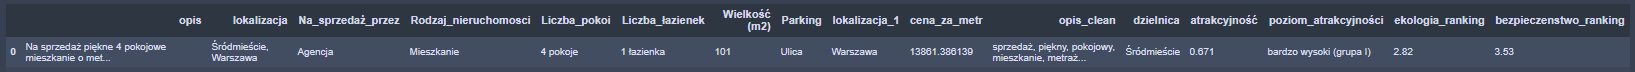

In [12]:
with open("./data/raw_data_2021_01_11_19_59_10.pkl", "rb") as fh:
  raw_data = pickle.load(fh)

In [13]:
raw_data.shape

(64632, 15)

In [14]:
clean_data=preprocessing(raw_data)

C:\Users\p_sierkin\Miniconda3\envs\real_estate\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
C:\Users\p_sierkin\Miniconda3\envs\real_estate\lib\site-packages\pandas\core\generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\p_sierkin\Miniconda3\envs\real_estate\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\p_sierkin\

In [15]:
clean_data.head()

,opis,cena,data dodania,lokalizacja,Na_sprzedaż_przez,Rodzaj_nieruchomosci,Liczba_pokoi,Liczba_łazienek,Wielkość (m2),Parking,mieszkanie_url,dzielnica,miasto,cena_za_metr
0,,499000,2020-12-26,"Śródmieście, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,38,Ulica,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Śródmieście,Warszawa,13131.578947
1,,499000,2020-12-26,"Śródmieście, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,38,Ulica,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Śródmieście,Warszawa,13131.578947
2,Apartament blisko biznesowego Mokotowa oraz Ur...,405000,2021-02-01,"Ursynów, Warszawa",Agencja,Mieszkanie,2 pokoje,NaN,34,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Ursynów,Warszawa,11911.764706
3,"3 pokojowy komfortowy apartament - od zaraz, m...",980000,2021-02-01,"Mokotów, Warszawa",Agencja,Mieszkanie,3 pokoje,NaN,80,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,12250.000000
4,Na sprzedaż 3 pokojowe mieszkanie na Warszawsk...,499000,2021-02-01,"Mokotów, Warszawa",Agencja,Mieszkanie,3 pokoje,1 łazienka,54,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,9240.740741


In [16]:
clean_numeric(clean_data)
#to check if data have inf and nan numbers 
# print(np.any(np.isinf(clean_data['cena_za_metr'])))
# print(clean_data['cena_za_metr'].isnull().sum())
# print(np.where(np.isnan(clean_data['cena_za_metr'])))
# print(clean_data.describe())  

C:\Users\p_sierkin\Miniconda3\envs\real_estate\lib\site-packages\pandas\core\frame.py:4527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
C:\Users\p_sierkin\Miniconda3\envs\real_estate\lib\site-packages\pandas\core\series.py:4439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,opis,cena,data dodania,lokalizacja,Na_sprzedaż_przez,Rodzaj_nieruchomosci,Liczba_pokoi,Liczba_łazienek,Wielkość (m2),Parking,mieszkanie_url,dzielnica,miasto,cena_za_metr
0,,499000,2020-12-26,"Śródmieście, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,38,Ulica,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Śródmieście,Warszawa,13131.578947
1,,499000,2020-12-26,"Śródmieście, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,38,Ulica,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Śródmieście,Warszawa,13131.578947
2,Apartament blisko biznesowego Mokotowa oraz Ur...,405000,2021-02-01,"Ursynów, Warszawa",Agencja,Mieszkanie,2 pokoje,NaN,34,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Ursynów,Warszawa,11911.764706
3,"3 pokojowy komfortowy apartament - od zaraz, m...",980000,2021-02-01,"Mokotów, Warszawa",Agencja,Mieszkanie,3 pokoje,NaN,80,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,12250.000000
4,Na sprzedaż 3 pokojowe mieszkanie na Warszawsk...,499000,2021-02-01,"Mokotów, Warszawa",Agencja,Mieszkanie,3 pokoje,1 łazienka,54,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,9240.740741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64501,Do sprzedania:\n\nDwupokojowe mieszkanie zloka...,480000,2021-11-01,"Białołęka, Warszawa",Agencja,Mieszkanie,2 pokoje,NaN,57,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Białołęka,Warszawa,8421.052632
64502,Do sprzedania:\n\nMieszkanie zlokalizowane na ...,600000,2021-11-01,"Ursus, Warszawa",Agencja,Mieszkanie,3 pokoje,1 łazienka,65,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Ursus,Warszawa,9230.769231
64503,"Nowe, dwu pokojowe mieszkanie o pow.ok. 44 m2 ...",615000,2021-11-01,"Mokotów, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,44,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,13977.272727
64504,Spacer Wirtualny https://app.lapentor.com/sphe...,499000,2021-11-01,"Mokotów, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,32,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,15593.750000


In [17]:
atrlist=get_atrakcyjnosc()
domlist=get_otodom()

In [18]:
map_atrakcyjnosc2(clean_data,atrlist)
map_otodom2(clean_data,domlist)

100%|██████████| 64506/64506 [00:00<00:00, 477794.41it/s]
C:\Users\p_sierkin\Miniconda3\envs\real_estate\lib\site-packages\ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\p_sierkin\Miniconda3\envs\real_estate\lib\site-packages\pandas\core\generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
100%|██████████| 64506/64506 [00:00<00:00, 658228.96it/s]
C:\Users\p_sierkin\Miniconda3\envs\real_estate\lib\site-packages\ipykernel_launcher.py:83: SettingWith

,opis,cena,data dodania,lokalizacja,Na_sprzedaż_przez,Rodzaj_nieruchomosci,Liczba_pokoi,Liczba_łazienek,Wielkość (m2),Parking,mieszkanie_url,dzielnica,miasto,cena_za_metr,atrakcyjnosc,poziom_atrakcyjnosci,ekologia_ranking,bezpieczenstwo_ranking
0,,499000,2020-12-26,"Śródmieście, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,38,Ulica,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Śródmieście,Warszawa,13131.578947,0.671,bardzo wysoki (grupa I),2.82,3.53
1,,499000,2020-12-26,"Śródmieście, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,38,Ulica,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Śródmieście,Warszawa,13131.578947,0.671,bardzo wysoki (grupa I),2.82,3.53
2,Apartament blisko biznesowego Mokotowa oraz Ur...,405000,2021-02-01,"Ursynów, Warszawa",Agencja,Mieszkanie,2 pokoje,NaN,34,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Ursynów,Warszawa,11911.764706,0.476,wysoki (grupa II),3.62,4.26
3,"3 pokojowy komfortowy apartament - od zaraz, m...",980000,2021-02-01,"Mokotów, Warszawa",Agencja,Mieszkanie,3 pokoje,NaN,80,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,12250.000000,0.592,wysoki (grupa II),3.19,3.75
4,Na sprzedaż 3 pokojowe mieszkanie na Warszawsk...,499000,2021-02-01,"Mokotów, Warszawa",Agencja,Mieszkanie,3 pokoje,1 łazienka,54,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,9240.740741,0.592,wysoki (grupa II),3.19,3.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64501,Do sprzedania:\n\nDwupokojowe mieszkanie zloka...,480000,2021-11-01,"Białołęka, Warszawa",Agencja,Mieszkanie,2 pokoje,NaN,57,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Białołęka,Warszawa,8421.052632,0.324,średni (grupa III),3.50,3.86
64502,Do sprzedania:\n\nMieszkanie zlokalizowane na ...,600000,2021-11-01,"Ursus, Warszawa",Agencja,Mieszkanie,3 pokoje,1 łazienka,65,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Ursus,Warszawa,9230.769231,0.390,średni (grupa III),3.10,4.08
64503,"Nowe, dwu pokojowe mieszkanie o pow.ok. 44 m2 ...",615000,2021-11-01,"Mokotów, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,44,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,13977.272727,0.592,wysoki (grupa II),3.19,3.75
64504,Spacer Wirtualny https://app.lapentor.com/sphe...,499000,2021-11-01,"Mokotów, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,32,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,15593.750000,0.592,wysoki (grupa II),3.19,3.75


In [ ]:
clean_data['opis_clean']=clean_data['opis'].progress_apply(lambda x: spacy_tokenizer_lemmatizer(x)).apply(lambda x: ' '.join(x))

  2%|▏         | 1086/64506 [03:16<3:55:34,  4.49it/s]

In [93]:
pkl_file = './data/clean_data_with_opis_clean' + str(datetime.now().strftime('%Y_%m_%d_%H_%M_%S')) + '.pkl'
#saving df into pickle 
clean_data.to_pickle(pkl_file)

In [94]:
with open("./data/clean_data_with_opis_clean2021_01_05_17_26_25.pkl", "rb") as fh:
  clean_data = pickle.load(fh)

In [95]:
clean_data.head()

,opis,cena,data dodania,lokalizacja,Na_sprzedaż_przez,Rodzaj_nieruchomosci,Liczba_pokoi,Liczba_łazienek,Wielkość (m2),Parking,mieszkanie_url,dzielnica,miasto,cena_za_metr,atrakcyjnosc,poziom_atrakcyjnosci,ekologia_ranking,bezpieczenstwo_ranking,opis_clean
0,Na sprzedaż piękne 4 pokojowe mieszkanie o met...,1400000,2020-12-26,"Śródmieście, Warszawa",Agencja,Mieszkanie,4 pokoje,1 łazienka,101,Ulica,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Śródmieście,Warszawa,13861.386139,0.671,bardzo wysoki (grupa I),2.82,3.53,"[sprzedaż, piękny, pokojowy, mieszkanie, metra..."
1,Ustawne 4-pokojowe mieszkanie położone na 2 pi...,925000,2020-12-26,"Ursynów, Warszawa",Agencja,Mieszkanie,4 pokoje,NaN,94,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Ursynów,Warszawa,9840.425532,0.476,wysoki (grupa II),3.62,4.26,"[ustawny, 4-pokojowy, mieszkanie, położony, pi..."
2,Szukasz lokum blisko Centrum Warszawy z dużym ...,499000,2020-12-26,"Śródmieście, Warszawa",Agencja,Mieszkanie,2 pokoje,1 łazienka,48,Ulica,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Śródmieście,Warszawa,10395.833333,0.671,bardzo wysoki (grupa I),2.82,3.53,"[szukać, lokum, blisko, centrum, warszawa, duż..."
3,___________________English Version below______...,2599000,2020-12-26,"Ursynów, Warszawa",Agencja,Dom,6 lub więcej pokoi,4 lub więcej łazienek,390,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Ursynów,Warszawa,6664.102564,0.476,wysoki (grupa II),3.62,4.26,[]
4,Na sprzedaż fajne dwupokojowe mieszkanie (z mo...,575000,2020-12-26,"Wola, Warszawa",Agencja,Mieszkanie,3 pokoje,1 łazienka,51,Ulica,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Wola,Warszawa,11274.509804,0.462,wysoki (grupa II),2.97,3.71,"[sprzedaż, fajny, dwupokojowy, mieszkanie, moż..."


In [98]:
clean_data.shape

(39812, 19)

In [17]:
######Actual collection from mongo preprocessed and create pickle from this 
# Connection to mongodb and loading data into df 
client = MongoClient(url_link)
db = client.GUMTREE
collection = db.mieszkania
data_mongo = pd.DataFrame(list(collection.find()))


In [6]:
with open("./data/raw_data_2021_01_11_19_59_10.pkl", "rb") as fh:
  raw_data = pickle.load(fh)

In [9]:
raw_data.drop_duplicates(subset=['mieszkanie_url'],inplace=True)

In [10]:
raw_data.shape

(26675, 15)

In [11]:
raw_data=preprocessing(raw_data)
raw_data=clean_numeric(raw_data)
atrlist=get_atrakcyjnosc()
domlist=get_otodom()
map_atrakcyjnosc2(raw_data,atrlist)
map_otodom2(raw_data,domlist)

C:\Users\p_sierkin\Miniconda3\envs\real_estate\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
C:\Users\p_sierkin\Miniconda3\envs\real_estate\lib\site-packages\pandas\core\generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\p_sierkin\Miniconda3\envs\real_estate\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\p_sierkin\

,opis,cena,data dodania,lokalizacja,Na_sprzedaż_przez,Rodzaj_nieruchomosci,Liczba_pokoi,Liczba_łazienek,Wielkość (m2),Parking,mieszkanie_url,dzielnica,miasto,cena_za_metr,atrakcyjnosc,poziom_atrakcyjnosci,ekologia_ranking,bezpieczenstwo_ranking
0,,499000,2020-12-26,"Śródmieście, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,38,Ulica,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Śródmieście,Warszawa,13131.578947,0.671,bardzo wysoki (grupa I),2.82,3.53
1,Apartament blisko biznesowego Mokotowa oraz Ur...,405000,2021-02-01,"Ursynów, Warszawa",Agencja,Mieszkanie,2 pokoje,NaN,34,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Ursynów,Warszawa,11911.764706,0.476,wysoki (grupa II),3.62,4.26
2,"3 pokojowy komfortowy apartament - od zaraz, m...",980000,2021-02-01,"Mokotów, Warszawa",Agencja,Mieszkanie,3 pokoje,NaN,80,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,12250.000000,0.592,wysoki (grupa II),3.19,3.75
3,Na sprzedaż 3 pokojowe mieszkanie na Warszawsk...,499000,2021-02-01,"Mokotów, Warszawa",Agencja,Mieszkanie,3 pokoje,1 łazienka,54,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,9240.740741,0.592,wysoki (grupa II),3.19,3.75
4,Ustawne 4-pokojowe mieszkanie położone na 1 pi...,1395000,2021-02-01,"Śródmieście, Warszawa",Agencja,Mieszkanie,4 pokoje,NaN,110,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Śródmieście,Warszawa,12681.818182,0.671,bardzo wysoki (grupa I),2.82,3.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26625,Do sprzedania:\n\nDwupokojowe mieszkanie zloka...,480000,2021-11-01,"Białołęka, Warszawa",Agencja,Mieszkanie,2 pokoje,NaN,57,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Białołęka,Warszawa,8421.052632,0.324,średni (grupa III),3.50,3.86
26626,Do sprzedania:\n\nMieszkanie zlokalizowane na ...,600000,2021-11-01,"Ursus, Warszawa",Agencja,Mieszkanie,3 pokoje,1 łazienka,65,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Ursus,Warszawa,9230.769231,0.390,średni (grupa III),3.10,4.08
26627,"Nowe, dwu pokojowe mieszkanie o pow.ok. 44 m2 ...",615000,2021-11-01,"Mokotów, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,44,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,13977.272727,0.592,wysoki (grupa II),3.19,3.75
26628,Spacer Wirtualny https://app.lapentor.com/sphe...,499000,2021-11-01,"Mokotów, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,32,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,15593.750000,0.592,wysoki (grupa II),3.19,3.75


In [12]:
raw_data['opis_clean']=raw_data['opis'].progress_apply(lambda x: spacy_tokenizer_lemmatizer(x)).progress_apply(lambda x: ' '.join(x))


100%|██████████| 26630/26630 [00:00<00:00, 42539.97it/s]
C:\Users\p_sierkin\Miniconda3\envs\real_estate\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
pkl_file = './data/data_clean' + str(datetime.now().strftime('%Y_%m_%d_%H_%M_%S')) + '.pkl'
#saving df into pickle 
raw_data.to_pickle(pkl_file)

In [20]:
data_mongo.head()

,opis,cena,data dodania,lokalizacja,Na_sprzedaż_przez,Rodzaj_nieruchomosci,Liczba_pokoi,Liczba_łazienek,Wielkość (m2),Parking,mieszkanie_url,dzielnica,miasto,cena_za_metr,atrakcyjnosc,poziom_atrakcyjnosci,ekologia_ranking,bezpieczenstwo_ranking,opis_clean
0,,499000,2020-12-26,"Śródmieście, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,38,Ulica,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Śródmieście,Warszawa,13131.578947,0.671,bardzo wysoki (grupa I),2.82,3.53,[]
1,,499000,2020-12-26,"Śródmieście, Warszawa",Właściciel,Mieszkanie,2 pokoje,1 łazienka,38,Ulica,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Śródmieście,Warszawa,13131.578947,0.671,bardzo wysoki (grupa I),2.82,3.53,[]
2,Apartament blisko biznesowego Mokotowa oraz Ur...,405000,2021-02-01,"Ursynów, Warszawa",Agencja,Mieszkanie,2 pokoje,NaN,34,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Ursynów,Warszawa,11911.764706,0.476,wysoki (grupa II),3.62,4.26,"[apartament, blisko, biznesowy, mokotów, ursynów]"
3,"3 pokojowy komfortowy apartament - od zaraz, m...",980000,2021-02-01,"Mokotów, Warszawa",Agencja,Mieszkanie,3 pokoje,NaN,80,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,12250.000000,0.592,wysoki (grupa II),3.19,3.75,"[pokojowy, komfortowy, apartament, zaraz, miej..."
4,Na sprzedaż 3 pokojowe mieszkanie na Warszawsk...,499000,2021-02-01,"Mokotów, Warszawa",Agencja,Mieszkanie,3 pokoje,1 łazienka,54,NaN,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,Mokotów,Warszawa,9240.740741,0.592,wysoki (grupa II),3.19,3.75,"[sprzedaż, pokojowy, mieszkanie, warszawski, m..."


In [21]:
pkl_file = './data/data_mongo_' + str(datetime.now().strftime('%Y_%m_%d_%H_%M_%S')) + '.pkl'
#saving df into pickle 
data_mongo.to_pickle(pkl_file)